In [158]:

import torch
from torch.nn import functional as FF
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler
from tqdm import tqdm
import yaml
import wandb
from utils.dataloader_jetnet import PointCloudDataloader
ckptdir="/gpfs/dust/maxwell/user/kaechben/thesis/jetnet30/"
model_name="ccnf"#"pf",,"nf","tnf"

ckpt="t_{}low.ckpt".format(model_name)
ckpt=ckptdir+ckpt
print(ckpt)
def load_model(ckpt,model):
    flow_state_dict = {k.replace('flow.', ''): v for k, v in ckpt["state_dict"].items() if 'flow' in k}
    if "adversarial" not in ckpt["hyper_parameters"].keys():
        ckpt["hyper_parameters"]["adversarial"]=False
    config=ckpt["hyper_parameters"]
    if "ckpt_flow" in config.keys():
        config["ckpt_flow"]="/".join(config["ckpt_flow"].split("/")[:-1])+"/jetnet30/"+config["ckpt_flow"].split("/")[-1]
    flow=model(**ckpt["hyper_parameters"])
    
    flow.flow.load_state_dict(flow_state_dict)
    if config["context_features"]>0 and config["pf"]:
        context_state_dict = {k.replace('shape.', ''): v for k, v in ckpt["state_dict"].items() if 'shape' in k}
        flow.shape.load_state_dict(context_state_dict)
        if config["adversarial"]:
            context_state_dict = {k.replace('dis_net.', ''): v for k, v in ckpt["state_dict"].items() if 'dis_net' in k}
            flow.dis_net.load_state_dict(context_state_dict)
    elif config["context_features"]>0 and config["model_name"]=="tnf":
        context_state_dict = {k.replace('gen_net.', ''): v for k, v in ckpt["state_dict"].items() if 'gen_net' in k}
        flow.gen_net.load_state_dict(context_state_dict)
    return flow
state_dict=torch.load(ckpt)
config=state_dict["hyper_parameters"]
config["model_name"]=model_name
if model_name=="ipf" or model_name=="pf" or model_name=="apf":
    config["pf"]=True
    from fit.fit_pnf import PNF as model  
elif model_name=="nf" or model_name=="ccnf" or model_name=="cnf":
    config["pf"]=False
    from fit.fit_nf import NF as model
elif model_name=="tnf":
    config["pf"]=False
    from fit.fit_tnf import TNF as model 


model=load_model(state_dict,model)

    

/gpfs/dust/maxwell/user/kaechben/thesis/jetnet30/t_ccnflow.ckpt


In [159]:


import pytorch_lightning as pl
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.weight_norm as weight_norm
from torch.nn import Parameter

data_module = PointCloudDataloader(**config)
data_module.setup("fit")
model.bins=[100,100,100]
model.n_dim = 3
model.scaler=data_module.scaler
model.w1m_best=0.01
model.min_pt=data_module.min_pt
model.max_pt=data_module.max_pt
mins=torch.ones(config["n_dim"]).unsqueeze(0)
maxs=torch.ones(config["n_dim"]).unsqueeze(0)
n=[]
for i in data_module.train_dataloader():
    mins=torch.min(torch.cat((mins,i[0][~i[1]].min(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    maxs=torch.max(torch.cat((maxs,i[0][~i[1]].max(0,keepdim=True)[0]),dim=0),dim=0)[0].unsqueeze(0)
    n.append((~i[1]).sum(1))
model.maxs=maxs.cuda()
model.mins=mins.cuda()
model.avg_n=torch.cat(n,dim=0).float().cuda().mean()
model.swa=False
model.scaler=model.scaler.to("cuda")
model.scaler.std=model.scaler.std.cuda()
model.scaled_mins=torch.tensor(data_module.mins).cuda()
model.scaled_maxs=torch.tensor(data_module.maxs).cuda()
# model.on_validation_epoch_start=on_validation_epoch_start
trainer = pl.Trainer(
        devices=1,
        accelerator="gpu",
    )
trainer.validate(model, dataloaders=data_module.test_dataloader())

tensor([0.1158, 0.1166, 0.0394])


/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_jetnet/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_ ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]sample lengths: 50000 50000


/gpfs/dust/maxwell/user/kaechben/.conda/envs/torch2_jetnet/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [216]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class plotting_thesis():
    '''This is a class that takes care of  plotting steps in the script,
        It is initialized with the following arguments:
        true=the simulated data, note that it needs to be scaled
        gen= Generated data , needs to be scaled
        step=The current step of the training, this is need for tensorboard
        model=the model that is trained, a bit of an overkill as it is only used to access the losses
        config=the config used for training
        logger=The logger used for tensorboard logging'''
    def __init__(self,step=None,logger=None,weight=1):

        self.step=step
        self.weight=weight
        self.fig_size1=[6.4, 6.4]
        self.fig_size2=[2*6.4, 6.4]
        self.fig_size3=[3*6.4, 6.4]
        self.fig_size4=[4*6.4, 6.4]
        self.alpha=0.3
        mpl.rcParams['lines.linewidth'] = 2
        font = { "size": 18}#"family": "normal",
        mpl.rc("font", **font)
        mpl.rc('lines', linewidth=2)
        sns.set_palette("Pastel1")
        self.cmap = sns.color_palette()
        if logger is not None:
            self.summary=logger
        else:
            self.summary = None
    def plot_ratio(self,h_real,h_fake,weighted,leg=-1,model_name=""):
        i = 0
        k = 0
        fig, ax = plt.subplots(2, 4, gridspec_kw={"height_ratios": [4, 1]}, figsize=self.fig_size4)
        # plt.suptitle("All Particles", fontsize=18)
        for v, name in zip(["eta", "phi", "pt", "m"], [r"relative pseudorapidity $\eta^{\tt rel}$", r"relative phi $\phi^{\tt rel}$", r"relative transverse momentum $p_T^{\tt rel}$", r"relative invariant jet mass $m^{\tt rel}$"]):
            main_ax_artists, sublot_ax_arists = h_fake[k].plot_ratio(
            h_real[k],
            ax_dict={"main_ax":ax[0,k],"ratio_ax":ax[1,k]},
            rp_ylabel=r"Ratio",
            bar_="blue",
            rp_num_label="Generated",
            rp_denom_label="Ground Truth",
            rp_uncert_draw_type="line",  # line or bar)
            )
            i += 1
            ax[0, k].set_xlabel("")
            ax[0, k].patches[1].set_fill(True)
            ax[0, k].ticklabel_format(axis="y", style="scientific", scilimits=(-3, 3), useMathText=True)
            ax[0, k].patches[1].set_fc(sns.color_palette()[1])
            ax[0, k].patches[1].set_edgecolor("black")
            ax[0, k].patches[1].set_linewidth(2)
            ax[0, k].patches[1].set_alpha(self.alpha)
            ax[1, k].set_xlabel(name)
            ax[0, k].set_ylabel("Counts")
            ax[1, k].set_ylabel("Ratio")
            ax[0, k].patches[0].set_lw(2)
            ax[0, k].get_legend().remove()
            ax[1,k].set_ylim(0.8,1.2)
            k += 1


        ax[0, leg].legend(loc="best", fontsize=18)
        handles, labels = ax[0, leg].get_legend_handles_labels()
        ax[0, -1].locator_params(nbins=4, axis="x")
        ax[1, -1].locator_params(nbins=4, axis="x")
        handles[1] = mpatches.Patch(color=sns.color_palette()[1], label="The red data")
        ax[0, leg].legend(handles, labels)
        plt.suptitle("Agreement between Ground Truth and Generated Data", fontsize=28, fontweight="bold")
        plt.tight_layout(pad=0.3)

        # if not save==None:
        plt.savefig("plots/{}_jetnet.pdf".format(model_name),format="pdf")
        plt.show()
        plt.close()

    def plot_corr(self,real,fake,model,leg=-1):
        # Sample data: batch_size of 100, 30 particles, 3 features each


        def compute_correlation_matrix(tensor):
     # Sum over the angular and radial layers


            # Compute the correlation matrix across the batch dimension
            correlation_matrix = np.corrcoef(tensor, rowvar=False)

            return correlation_matrix
        diffs=[]
        for name,data in zip(["Ground Truth","Generated"],[real,fake]):
            # Compute correlation for each batch and then average
            correlations = []
            sorted_data, indices = torch.sort(data[:,:,2], dim=1, descending=True)

            # Use the indices to reorder the data
            data = torch.gather(data, 1, indices.unsqueeze(-1).expand(-1, -1, 3)).numpy()
            for feature_idx in range(3):
                correlation_matrix = compute_correlation_matrix(data[:, :, feature_idx])

                correlations.append(correlation_matrix)
                diffs.append(correlation_matrix)
            # Convert tensors to numpy arrays for plotting
            # Plot heatmaps
            fig, axes = plt.subplots(1, 3, figsize=self.fig_size3)
            fig.suptitle("Correlations between Particles for {} Data".format(name), fontsize=28, fontweight="bold")
            sns.heatmap(correlations[0], ax=axes[0], cmap='coolwarm', cbar=False,vmin=-1,vmax=1)
            axes[0].set_title(r'$\eta^{rel}$')

            sns.heatmap(correlations[1], ax=axes[1], cmap='coolwarm', cbar=False,vmin=-1,vmax=1)
            axes[1].set_title(r'$\phi^{rel}$')

            cax3=sns.heatmap(correlations[2], ax=axes[2], cmap='coolwarm',cbar=False,vmin=-1,vmax=1
                             )
            axes[2].set_title(r'$p_T^{rel}$')
            for ax in axes:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlabel("Particles")
                ax.set_ylabel("Particles")
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            fig.colorbar(cax3.collections[0], cax=cbar_ax)
            plt.tight_layout(rect=[0, 0, 0.9, 1])
            if name=="Ground Truth":
                plt.savefig("plots/corrGroundTruth.pdf",format="pdf")
            else:
                plt.savefig("plots/corr"+model+".pdf",format="pdf")
            plt.show()
        diff=[diffs[0]-diffs[3],diffs[1]-diffs[4],diffs[2]-diffs[5]]

        fig, axes = plt.subplots(1, 3, figsize=self.fig_size3)
        fig.suptitle(r"$\Delta$Ground Truth - Generated Data Correlations between Particles", fontsize=28, fontweight="bold")
        sns.heatmap(diff[0], ax=axes[0], cmap='coolwarm', cbar=False,vmin=-.1,vmax=.1)
        axes[0].set_title(r'$\eta^{rel}$')

        sns.heatmap(diff[1], ax=axes[1], cmap='coolwarm', cbar=False,vmin=-.1,vmax=.1)
        axes[1].set_title(r'$\phi^{rel}$')

        cax3=sns.heatmap(diff[2], ax=axes[2], cmap='coolwarm',cbar=False,vmin=-.1,vmax=.1)
        axes[2].set_title(r'$p_T^{rel}$')
        for ax in axes:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel("Particles")
            ax.set_ylabel("Particles")
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(cax3.collections[0], cax=cbar_ax)
        plt.tight_layout(rect=[0, 0, 0.9, 1])
        plt.savefig("plots/diff_"+model+name+".pdf",format="pdf")
        plt.show()
    def plot_masses(self,hist_dict,weighted,leg=-1,model_name=""):
        i = 0
        k = 0
        fig, ax = plt.subplots(1, 4, figsize=self.fig_size4)
        s=0
        # plt.suptitle("All Particles", fontsize=18)
 
        for m in hist_dict.keys():
            k=0
            i=0
            s+=1
            for v, name in zip(["eta", "phi", "pt", "m"], [r"relative pseudorapidity $\eta^{\tt rel}$", r"relative phi $\phi^{\tt rel}$", r"relative transverse momentum $p_T^{\tt rel}$", r"relative invariant jet mass $m^{\tt rel}$"]):
                l=["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O"]
                hist_dict[m][k].axes.name=l[s]
                if m=="true":
                    hist_dict[m][k].project(str(l[s])).plot1d(ax=ax[k],density=True)
                    ax[k].patches[-1].set_color("black")
                else:
                    hist_dict[m][k].project(str(l[s])).plot1d(ax=ax[k],density=True)
                    ax[k].patches[-1].set_color(self.cmap[s-1])
                i += 1
                ax[k].set_xlabel(name)
                
                # ax[k].ticklabel_format(axis="y", style="scientific", scilimits=(-3, 3), useMathText=True)
                ax[k].set_ylabel("Counts (Normalized)")
                ax[k].patches[-1].set_lw(3)
                if k<3:
                    ax[k].set_yscale("log")
                k += 1
            # ax[-1].set_xlim(0,0.5)
            ax[k-1].patches[-1].set_alpha(1)

        handles = [mpatches.Patch(color=sns.color_palette()[z], label=label) if label!="Ground Truth" else mpatches.Patch(color="black", label=label) for z, label in enumerate(hist_dict.keys())]
        ax[-1].legend(handles=handles, loc="best", fontsize=18)
        # ax[ -1].locator_params(nbins=4, axis="x")
    
        plt.suptitle("Distribution for Different Mass Conditionings", fontsize=28, fontweight="bold")
        plt.tight_layout(pad=0.3)

            # if not save==None:
        plt.savefig("plots/mass_conditioning_jetnet.pdf".format(model_name),format="pdf")
        plt.show()
        plt.close()

# from utils.helpers import get_hists,mass
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# import seaborn as sns
# import matplotlib.patches as mpatches
# fake=torch.cat(model.fake)
# true=torch.cat(model.batch)
# m_f,m_t=mass(fake),mass(true)
# mins=torch.quantile(torch.cat((fake.reshape(-1,3),true.reshape(-1,3))),0.001,dim=0)
# maxs=torch.quantile(torch.cat((fake.reshape(-1,3),true.reshape(-1,3))),0.999,dim=0)
# fake=torch.clamp(fake,min=mins,max=maxs)
# true=torch.clamp(true,min=mins,max=maxs)
# mins=torch.cat((mins,torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0).unsqueeze(0)))
# maxs=torch.cat((maxs,torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0).unsqueeze(0)))*1.01
# m_f=torch.clamp(m_f,min=torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0),max=torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0))
# m_t=torch.clamp(m_t,min=torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0),max=torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0))
# hists=get_hists([30,30,30,30],mins,maxs,calo=model.name=="calo")
# masks=torch.cat(model.masks) 

# for var in range(3):
#     hists["hists_real"][var].fill(true.reshape(-1,3)[(true.reshape(-1,3)!=0).all(1)][:,var].cpu().numpy())
#     hists["hists_fake"][var].fill(fake.reshape(-1,3)[(fake.reshape(-1,3)!=0).all(1)][:,var].cpu().numpy())
# hists["hists_real"][3].fill(m_t.cpu().numpy())
# hists["hists_fake"][3].fill(m_f.cpu().numpy())

# plot=plotting_thesis()
# plot.plot_ratio(hists["hists_real"],hists["hists_fake"],weighted=False,leg=2,model_name=model_name)
# plot.plot_corr(true,fake,model_name,leg=-1)


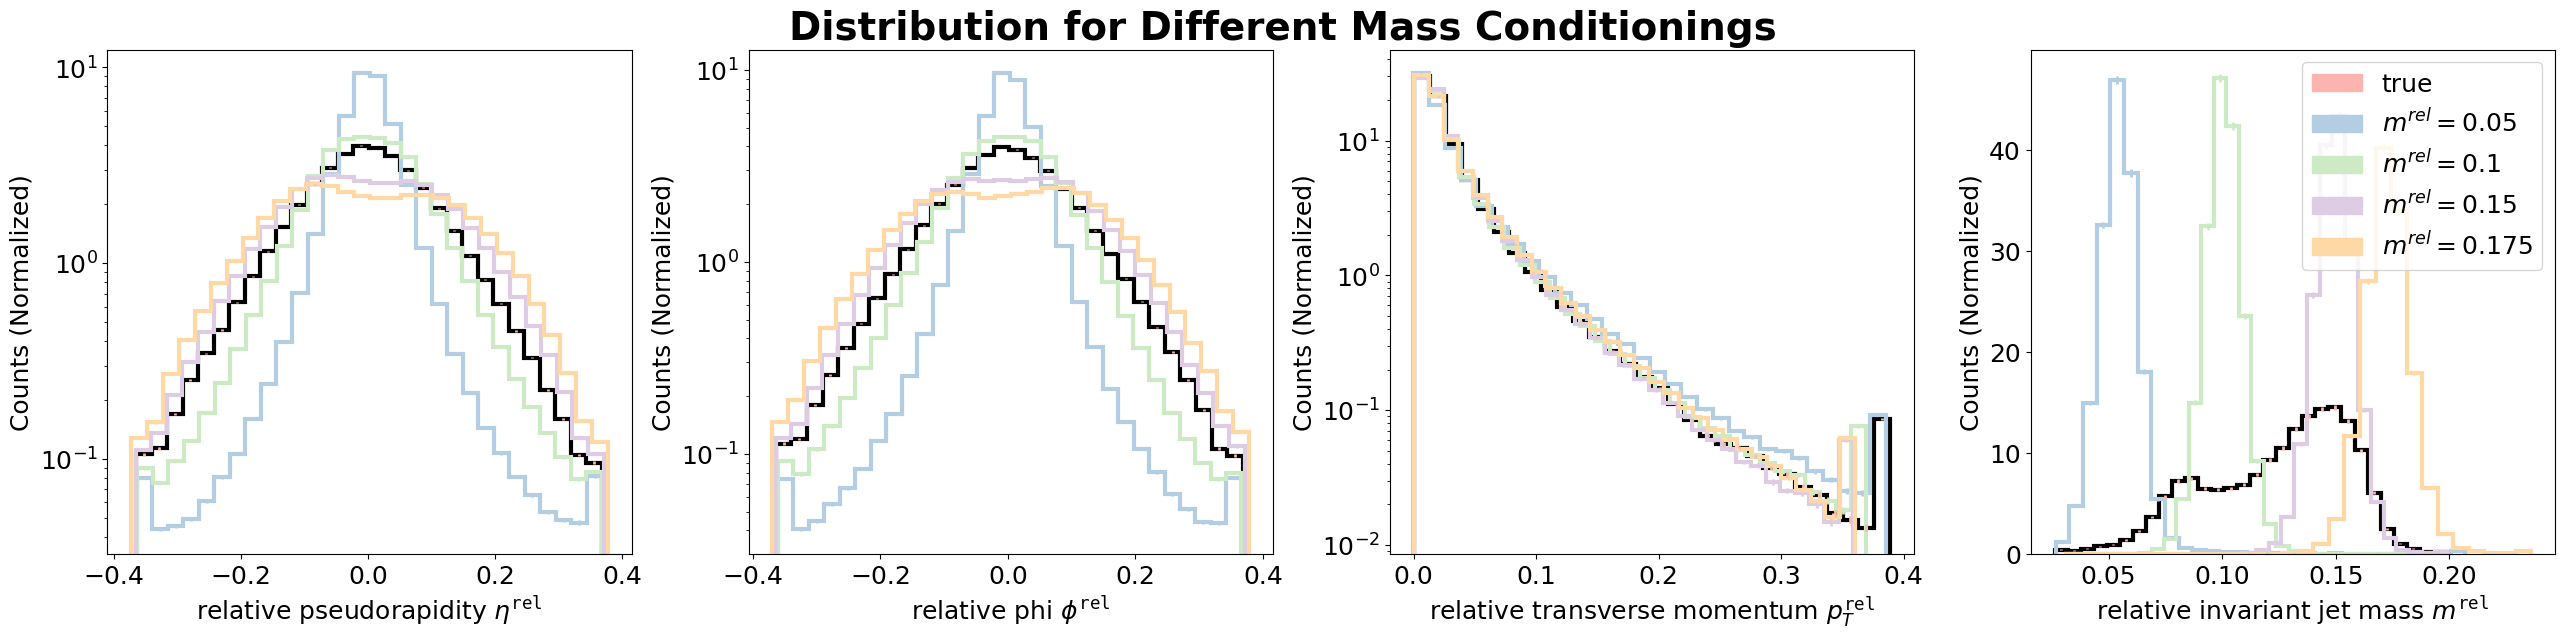

In [217]:
from utils.helpers import  mass,get_hists
plot=plotting_thesis()
samples={}
# model.flow.to("cuda")
hist_dict={}
with torch.no_grad():
    for m in [0.05,0.1,0.15,0.175]:
        for i in data_module.test_dataloader():
            i=i[0].cuda()
            samples["true"]=model.scaler.inverse_transform(i.reshape(-1,30,3)).cpu()

            samples[r"$m^{}={}$".format("{rel}",m)]=model.scaler.inverse_transform(model.flow.sample(1,torch.ones(len(i),1).cuda()*m,).reshape(-1,30,3)).cpu()
            
for k in samples.keys():
    fake=samples[k]
    true=samples["true"].reshape(-1,30,3)
    m_f,m_t=mass(fake),mass(true)
    mins=torch.quantile(torch.cat((fake.reshape(-1,3),true.reshape(-1,3))),0.001,dim=0)
    maxs=torch.quantile(torch.cat((fake.reshape(-1,3),true.reshape(-1,3))),0.999,dim=0)
    fake=torch.clamp(fake,min=mins,max=maxs)
    true=torch.clamp(true,min=mins,max=maxs)
    mins=torch.cat((mins,torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0).unsqueeze(0)))
    maxs=torch.cat((maxs,torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0).unsqueeze(0)))*1.01
    m_f=torch.clamp(m_f,min=torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0),max=torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0))
    m_t=torch.clamp(m_t,min=torch.quantile(torch.cat((m_f,m_t)),0.001,dim=0),max=torch.quantile(torch.cat((m_f,m_t)),0.999,dim=0))
    hists=get_hists([30,30,30,30],mins,maxs,calo=model.name=="calo")
    masks=torch.cat(model.masks) 

    for var in range(3):
        hists["hists_real"][var].fill(true.reshape(-1,3)[(true.reshape(-1,3)!=0).all(1)][:,var].cpu().numpy())
        hists["hists_fake"][var].fill(fake.reshape(-1,3)[(fake.reshape(-1,3)!=0).all(1)][:,var].cpu().numpy())
    hists["hists_real"][3].fill(m_t.cpu().numpy())
    hists["hists_fake"][3].fill(m_f.cpu().numpy())
    hist_dict[k]=hists["hists_fake"]
plot.plot_masses(hist_dict,weighted=False,leg=2,model_name=model_name+"_"+str(k))


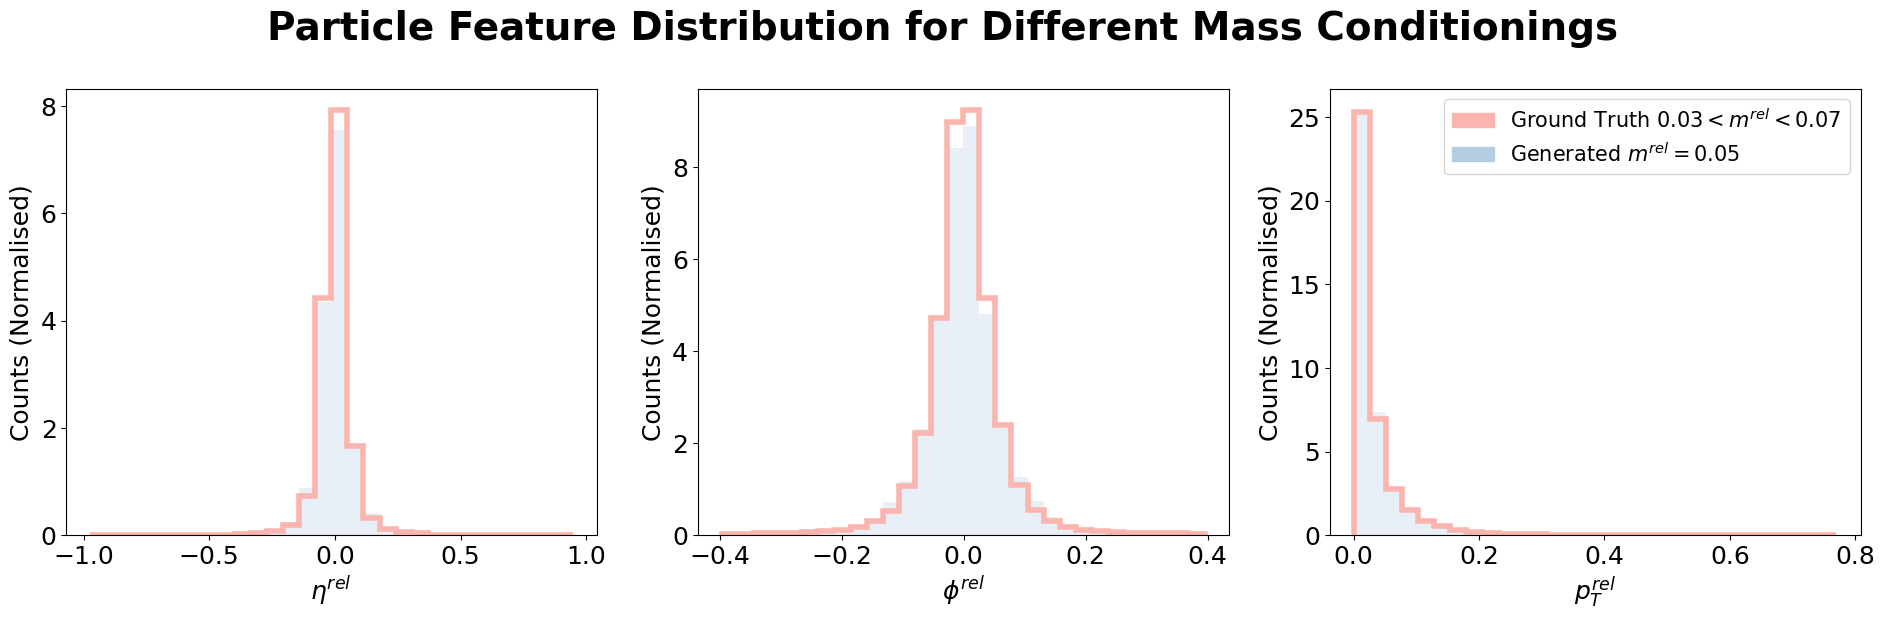

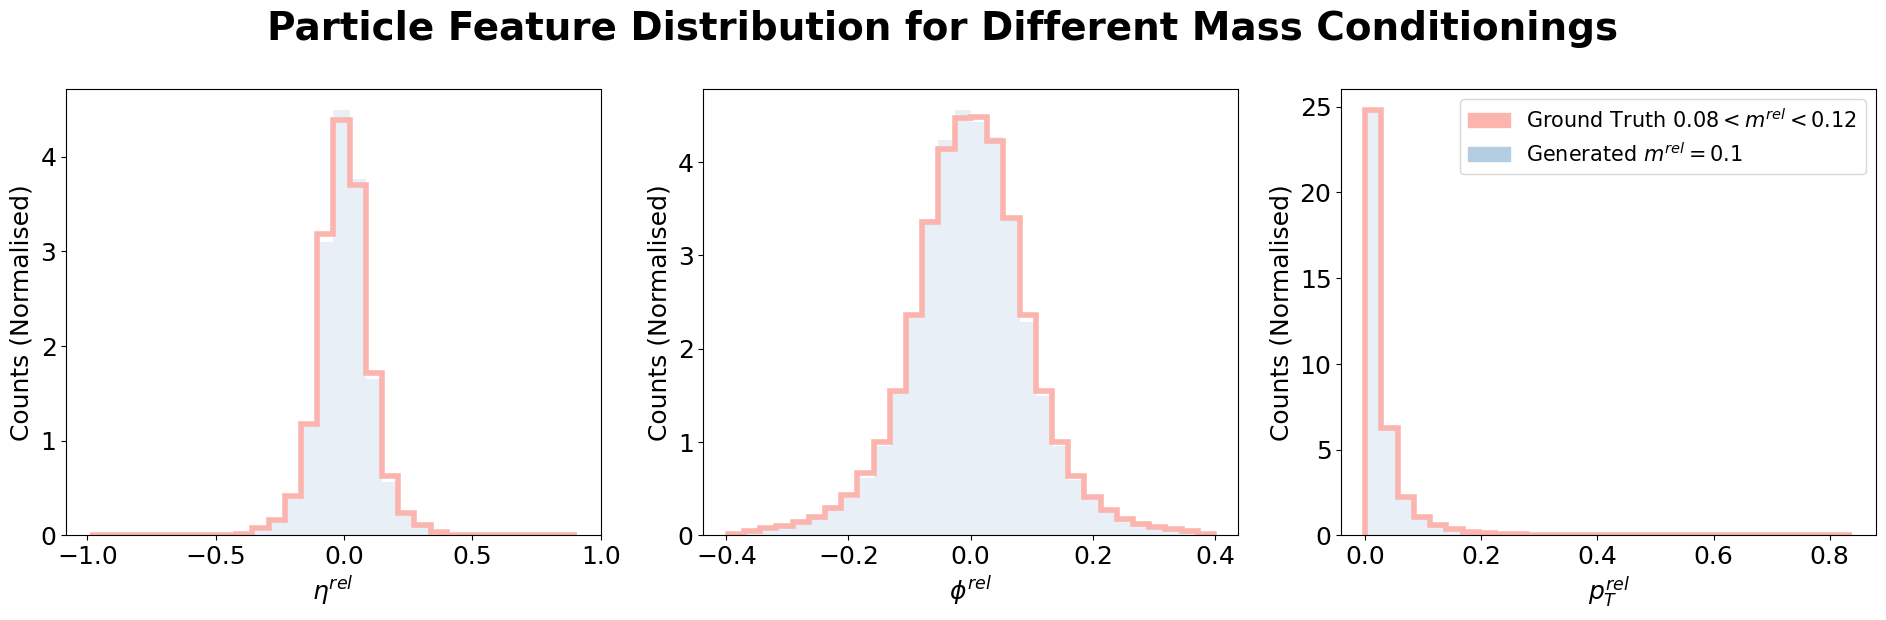

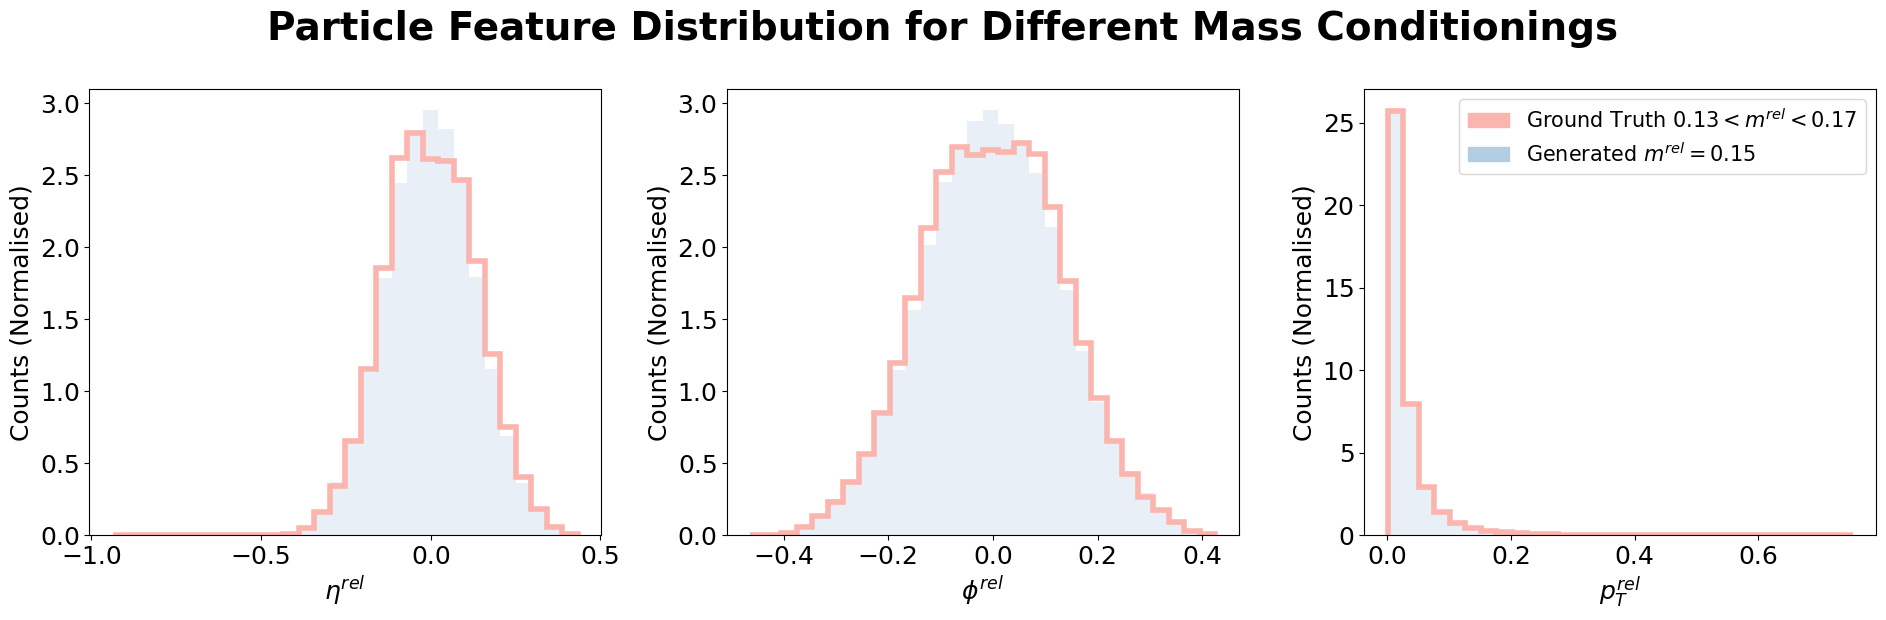

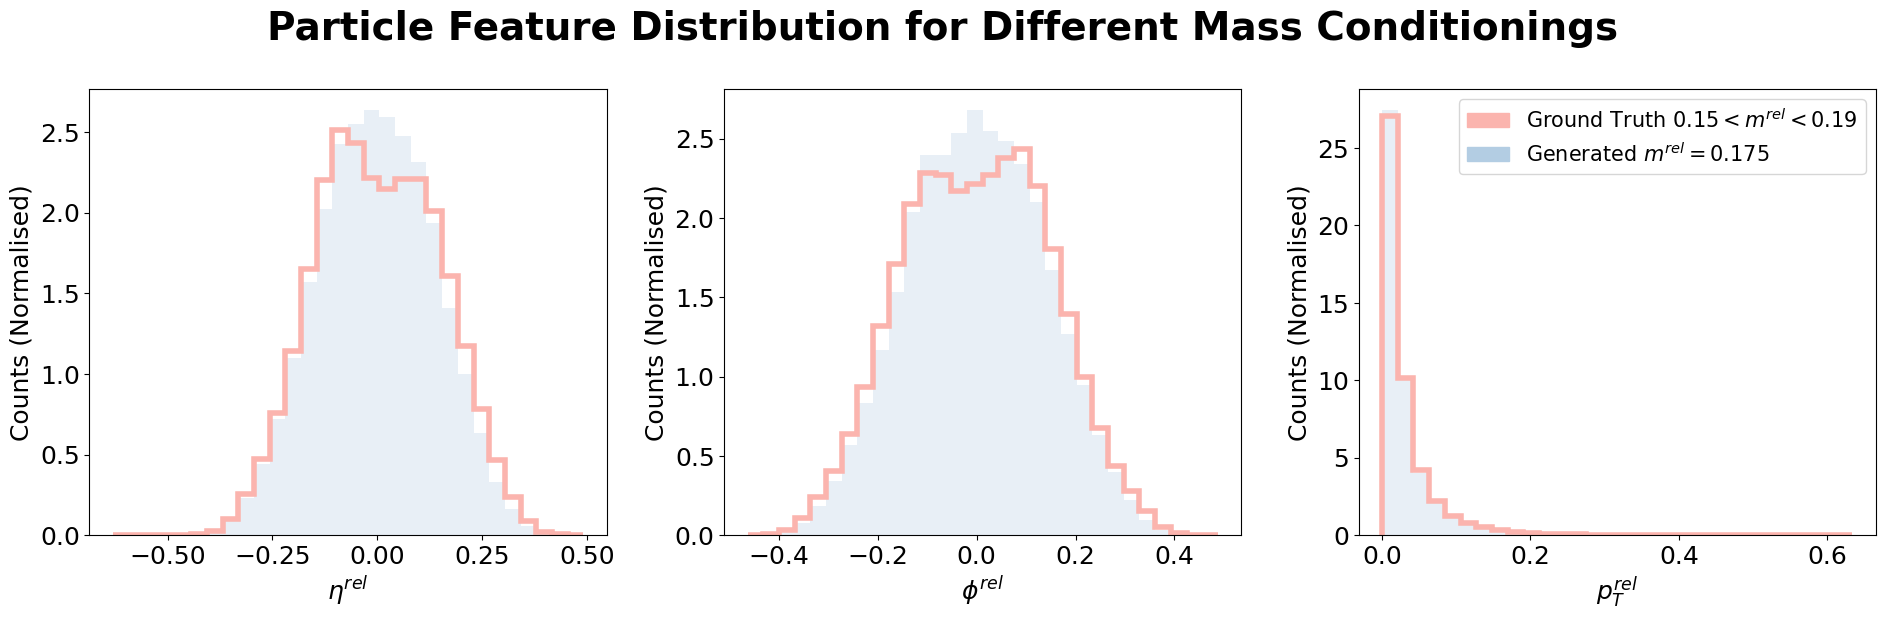

In [257]:
i=0
for k in samples.keys():
    if k=="true":
        continue
    fake=samples[k]
    fig,ax=plt.subplots(1,3,figsize=plot.fig_size3)

    for i in range(3):
        true=samples["true"].reshape(-1,30,3).clone()

        m_up=float(k.split("=")[-1].split("$")[0])+0.02
        true=true[mass(true[:,:,:])<m_up]
        m_down=float(k.split("=")[-1].split("$")[0])-0.02
        true=true[mass(true[:,:,:])>m_down]
        
        _,b,_=ax[i].hist(true.reshape(-1,3)[:,i].numpy(),bins=30,alpha=0.3,label="Ground Truth ${:.2f}< m^{}<{:.2f}$".format(m_down,"{rel}",m_up),color=plot.cmap[1],density=1)
        ax[i].set_ylabel("Counts (Normalised)")
        # ax2 =ax[i].twinx()
        ax[i].ticklabel_format(axis="y", style="scientific", scilimits=(-3, 3), useMathText=True)
        # ax2.ticklabel_format(axis="y", style="scientific", scilimits=(-3, 3), useMathText=True)
        ax[i].hist(fake.reshape(-1,3)[:,i].numpy(),bins=b,alpha=1,label="Generated",histtype="step",lw=4,density=1)
        # ax2.set_ylabel("Counts Generated")
        handles = [mpatches.Patch(color=sns.color_palette()[z], label=label)  for z, label in enumerate(["Ground Truth ${:.2f}< m^{}<{:.2f}$".format(m_down,"{rel}",m_up),"Generated "+k])]
        ax[-1].legend(handles=handles, fontsize=15,loc="upper right")
        ax[i].set_xlabel(["$\eta^{rel}$","$\phi^{rel}$","$p_T^{rel}$"][i])
    plt.suptitle("Particle Feature Distribution for Different Mass Conditionings", fontsize=28, fontweight="bold")
    plt.tight_layout()
    plt.savefig("plots/feature_mass_conditioning_{}.pdf".format(k.split("=")[-1].split("$")[0]),format="pdf")
    plt.show()

(array([1.700e+01, 5.400e+01, 1.270e+02, 1.800e+02, 2.820e+02, 3.980e+02,
        7.490e+02, 1.333e+03, 2.315e+03, 2.723e+03, 2.482e+03, 2.368e+03,
        2.423e+03, 2.802e+03, 3.395e+03, 4.007e+03, 4.844e+03, 5.324e+03,
        5.292e+03, 4.522e+03, 2.786e+03, 1.015e+03, 3.230e+02, 1.440e+02,
        5.800e+01, 1.800e+01, 5.000e+00, 1.100e+01, 2.000e+00, 1.000e+00]),
 array([0.01354926, 0.02093478, 0.02832031, 0.03570583, 0.04309136,
        0.05047688, 0.05786241, 0.06524793, 0.07263346, 0.08001898,
        0.08740451, 0.09479003, 0.10217556, 0.10956109, 0.11694662,
        0.12433214, 0.13171767, 0.13910319, 0.14648871, 0.15387423,
        0.16125977, 0.16864529, 0.17603081, 0.18341634, 0.19080187,
        0.1981874 , 0.20557292, 0.21295844, 0.22034398, 0.2277295 ,
        0.23511502]),
 <BarContainer object of 30 artists>)

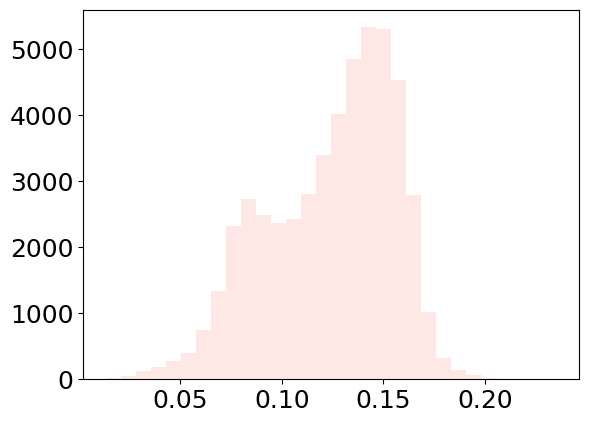

In [207]:
plt.hist(mass(samples["true"]).numpy(),bins=30,alpha=0.3,label="Ground Truth")